# Quick start

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, 
                             CountCB, MoranICB, PriorCB)

from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
red, black = '#BF360C', '#263238'

### Create a vector grid from a given raster

In [106]:
fname_raster = '../files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [107]:
gdf_grid.head()

,loc_id,geometry
0,0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


<Axes: >

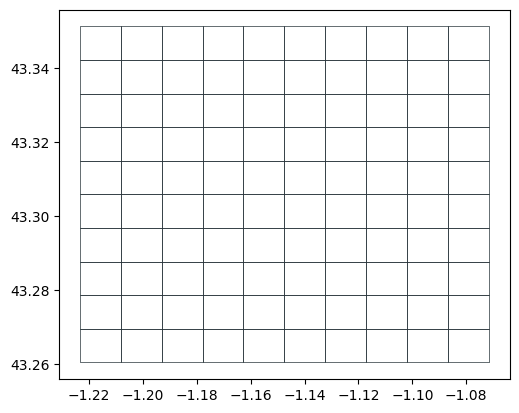

In [108]:
gdf_grid.boundary.plot(color=black, lw=0.5)

### Emulating data collection

#### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

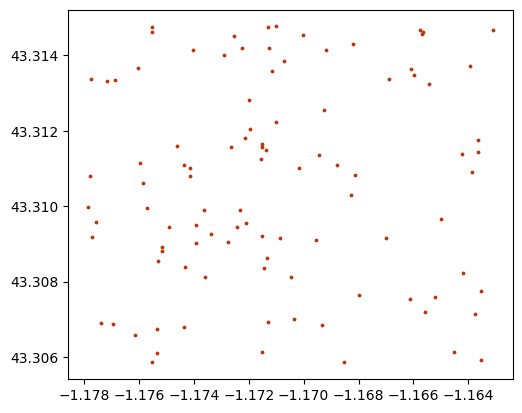

In [109]:
loc_id = 35
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=3, color=red)

In [110]:
sampling_locs

35    MULTIPOINT (-1.17784 43.30997, -1.17777 43.310...
Name: sampled_points, dtype: geometry

#### Emulate data collection

We will simulate a data collection process over a set of areas, which could be administrative units or a gridded version of them. For each area, we will specify the number of measurements to be taken, which we will simulate by generating random numbers between 1 and 100.

For each area, we will follow the following steps:

- **Generate random sample locations**: we will create a set of random coordinates within the bounds of the area, where we will simulate the collection of data.
- **Emulate measurement data**: for each sample location, we will extract the corresponding value from a given raster dataset, which we will use to simulate the actual measurement.

This iterative process will allow us to generate a simulated dataset of measurements, which we can then use for further analysis and modeling.

We will emulate data collection from the raster shown below:

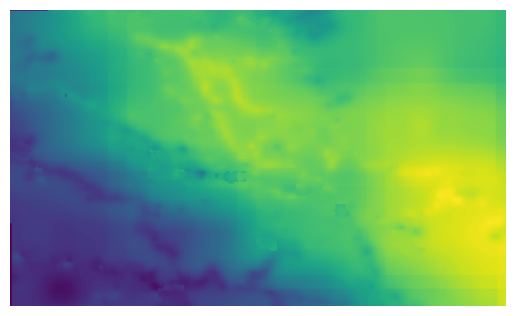

In [111]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

Let's start with a single area as an example:

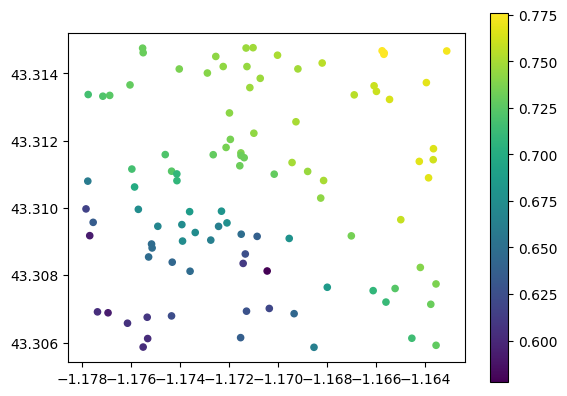

In [112]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)
gdf_samples.plot(column='value', s=20, legend=True);

In [113]:
gdf_samples.head()

,loc_id,geometry,value
0,35,POINT (-1.17784 43.30997),0.616764
1,35,POINT (-1.17777 43.31080),0.659577
2,35,POINT (-1.17776 43.31337),0.716917
3,35,POINT (-1.17769 43.30918),0.592433
4,35,POINT (-1.17755 43.30957),0.634380


Than for all areas iteratively:

In [114]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)

In [115]:
gdf_samples_t0.head()

,loc_id,geometry,value
0,0,POINT (-1.22310 43.26898),0.000000
1,0,POINT (-1.22082 43.26100),0.140117
2,0,POINT (-1.22012 43.26547),0.151198
3,0,POINT (-1.21829 43.26844),0.139755
4,0,POINT (-1.21667 43.26304),0.130322


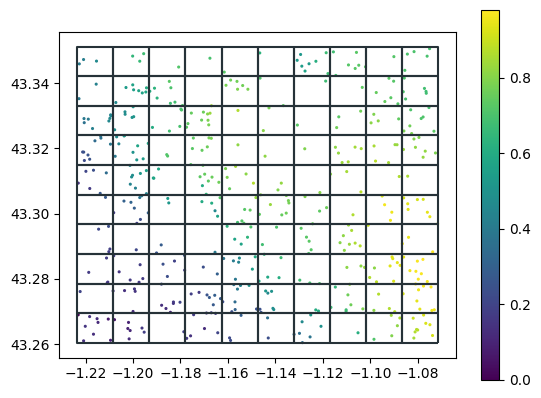

In [116]:
ax = gdf_samples_t0.plot(column='value', s=1.5, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [117]:
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), 
                               CountCB(), MoranICB(k=5), 
                               PriorCB(gdf_grid, fname_raster)])

In [118]:
state.get(loc_id=1, as_numpy=True)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I',
        'Moran_p_sim', 'Prior'], dtype='<U18'),
 array([ 0.19914412,  0.134533  ,  0.03230556,  2.        , -0.13753465,
         0.43      ,  0.12572713]))

## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative


In [119]:
state = State(gdf_samples_t0, [MaxCB(), StdCB(), PriorCB(gdf_grid, fname_raster)])
optimizer = Optimizer(state = state)
matrix = optimizer.build_matrix(polygon_list = gdf_samples_t0.loc_id.unique())

ranking = optimizer.rank(
        x_matrix = matrix,
        alt_names=None,
        is_benefit_x=[True, False, True],
        n_method="linear3",
        w_vector=[0.2, 0.3, 0.5],
        c_method=None,
        w_method=None,
        s_method="TOPSIS",
    )


In [120]:
# high values --> good alternatives
print(ranking)

[('84', 0.9437304110305142, 1), ('48', 0.9356113868797502, 2), ('93', 0.9276488191372031, 3), ('96', 0.916724746962808, 4), ('86', 0.9156720217138578, 5), ('95', 0.9120917315823448, 6), ('47', 0.9056265775792913, 7), ('57', 0.9017707517317192, 8), ('94', 0.9006518207412859, 9), ('75', 0.8904039638396498, 10), ('92', 0.8900268545382386, 11), ('39', 0.8825160232147924, 12), ('66', 0.88166432951185, 13), ('67', 0.8736386424047518, 14), ('73', 0.8703516593373964, 15), ('49', 0.866766012161169, 16), ('58', 0.8633918782331735, 17), ('85', 0.8601358447991564, 18), ('68', 0.8544258388074777, 19), ('90', 0.8454923886382977, 20), ('63', 0.8446248210998205, 21), ('50', 0.8441044311085364, 22), ('56', 0.8435271760716833, 23), ('40', 0.8386376409003584, 24), ('77', 0.8373557173552357, 25), ('64', 0.8357926663289682, 26), ('97', 0.8357757524150148, 27), ('59', 0.8356992233542982, 28), ('79', 0.8355202520721915, 29), ('100', 0.833308419432934, 30), ('30', 0.8316450055070942, 31), ('87', 0.82879164928

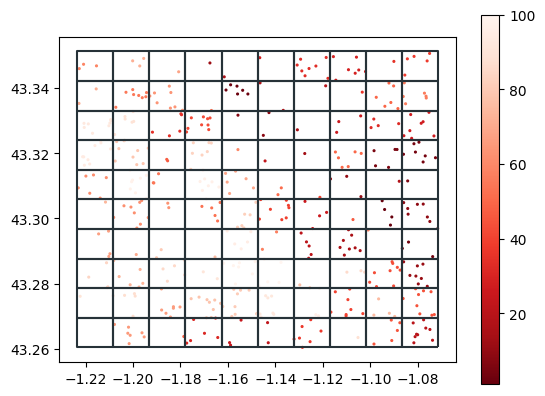

In [127]:
ranking_dict = {}
for alt in ranking:
    ranking_dict[int(alt[0])] = int(alt[2])
    
gdf_samples_t0["ranking"] = gdf_samples_t0.loc_id.map(ranking_dict)

ax = gdf_samples_t0.plot(column='ranking', s=1.5, legend=True, colormap='Reds_r')
gdf_grid.boundary.plot(color=black, ax=ax);

In [122]:
# map the rank to a number of new samples


[('84', 0.9437304110305142, 1), ('48', 0.9356113868797502, 2), ('93', 0.9276488191372031, 3), ('96', 0.916724746962808, 4), ('86', 0.9156720217138578, 5), ('95', 0.9120917315823448, 6), ('47', 0.9056265775792913, 7), ('57', 0.9017707517317192, 8), ('94', 0.9006518207412859, 9), ('75', 0.8904039638396498, 10), ('92', 0.8900268545382386, 11), ('39', 0.8825160232147924, 12), ('66', 0.88166432951185, 13), ('67', 0.8736386424047518, 14), ('73', 0.8703516593373964, 15), ('49', 0.866766012161169, 16), ('58', 0.8633918782331735, 17), ('85', 0.8601358447991564, 18), ('68', 0.8544258388074777, 19), ('90', 0.8454923886382977, 20), ('63', 0.8446248210998205, 21), ('50', 0.8441044311085364, 22), ('56', 0.8435271760716833, 23), ('40', 0.8386376409003584, 24), ('77', 0.8373557173552357, 25), ('64', 0.8357926663289682, 26), ('97', 0.8357757524150148, 27), ('59', 0.8356992233542982, 28), ('79', 0.8355202520721915, 29), ('100', 0.833308419432934, 30), ('30', 0.8316450055070942, 31), ('87', 0.82879164928

In [ ]:
# go for T + 1

